In [1]:
import pandas as pd
import numpy as np
import librosa
import pickle, gzip
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from collections import defaultdict
from numpy.fft import fft
import math
from scipy.signal import lfilter, stft
from scipy.stats import zscore
from scipy.io import wavfile
import gc

## Create a symbolic link to the database

The utterance .wav files should be located in folder `audio` and features written to folder `features`. Modify as needed. The .wav folder structure is:

```
audio/  
   +---CHN/
   |     +----G0021/
   |             |------G00021S1053.wav
   |             |------   .
   |             |------   .
   +---IND
   +--- .
   +--- .
   +---US
```   
   
If the database is located in harddisk, create a symbolic link to this notebook's working directory. 

In [2]:
#create symbolic link as database is located in harddisk
!ln -s /Volumes/AIWorks/accented_ASR/audio/ ~/MSAI/Accent/AccentRecognition/audio
!ln -s /Volumes/AIWorks/accented_ASR/features/ ~/MSAI/Accent/AccentRecognition/features

ln: /Users/samsudinng/MSAI/Accent/AccentRecognition/audio/audio: File exists
ln: /Users/samsudinng/MSAI/Accent/AccentRecognition/features/features: File exists


In [3]:
#############################
# CONSTANTS AND LOOKUP TABLES 
#############################

#to map accent from Kaldi utt2accent to the corresponding accent folder
accent_dir = {
    'BRITISH'   : 'UK',       
    'AMERICAN'  : 'US',
    'PORTUGUESE': 'PT',  
    'KOREAN'    : 'KR',
    'JAPANESE'  : 'JPN',
    'RUSSIAN'   : 'RU',
    'CHINESE'   : 'CHN',
    'INDIAN'    : 'IND'   
}

#various spectrogram parameters
spectrogram_params = {
    'vggvox': {    # this is the same setting as VGG VoxCeleb1
        'window'        : 'hamming',
        'sampling_freq' : 16000,
        'win_len'       : 25, #msec
        'hop_len'       : 10, #msec
        'ndft'          : 512,
        'output_folder' : 'vggvox_logspec512'
    }
}

## 0. Set the parameter here (file paths, spectrogram parameters)

In [4]:
############################
# FILE RELATED 
############################

# use same split as Kaldi features
train_label_file ='./features_dump/trainv2/utt2accent'
dev_label_file ='./features_dump/devv2/utt2accent'
train_gender_label_file ='./features_dump/trainv2/utt2sex'
dev_gender_label_file ='./features_dump/devv2/utt2sex'
train_age_label_file ='./features_dump/trainv2/utt2age'
dev_age_label_file ='./features_dump/devv2/utt2age'
test_label_file ='./features_dump/testRmOOS/utt2accent'
train_on_subset = {'activate': True, 'size':0.3}
feature_setting = 'vggvox'


############################
# SPECTROGRAM PARAMETERS
############################
spec_params = spectrogram_params[feature_setting]

#path to the audio
wavdir = 'audio/'
outdir = f"features/{spec_params['output_folder']}/"


## 1. Get the wav file paths for each utterance in train, dev and test set

The paths and metadata is contained in dataframes `train_df`, `dev_df` and `test_df`. Each dataframe contain the following columns:

1. `utt`    : the utterance label
2. `label`  : the accent label (int, {0 .. 7})
3. `gender` : the gender label (int, {0 .. 1})
4. `age`    : the age (int)
5. `wavfile`: full path to the utterance's .wav file


|    |utt	                                        |label|gender    |age    |wavfile|
|:---|:---|:---|:---|:---|:---|
|0	|AESRC2020-AMERICAN-ACCENT-G00473-G00473S1001	|0	  |1	     |21	 |audio/US/G00473/G00473S1001.wav|
|1	|AESRC2020-AMERICAN-ACCENT-G00473-G00473S1002	|0	  |1	     |21	 |audio/US/G00473/G00473S1002.wav|
|2	|AESRC2020-AMERICAN-ACCENT-G00473-G00473S1003	|0	  |1	     |21	 |audio/US/G00473/G00473S1003.wav|
|3	|AESRC2020-AMERICAN-ACCENT-G00473-G00473S1004	|0	  |1	     |21	 |audio/US/G00473/G00473S1004.wav|
|4	|AESRC2020-AMERICAN-ACCENT-G00473-G00473S1006	|0	  |1	     |21	 |audio/US/G00473/G00473S1006.wav|


In [5]:
# Train labels
train_labels = pd.read_csv(train_label_file, names = ['utt','label'], header=None, 
                           delim_whitespace=True,index_col='utt')
gender = pd.read_csv(train_gender_label_file, names = ['utt','gender'],header=None, 
                     delim_whitespace=True,index_col='utt')
age = pd.read_csv(train_age_label_file, names = ['utt','age'], header=None, 
                  delim_whitespace=True,index_col='utt')
train_labels['gender'] = gender
train_labels['age'] = age
train_labels.reset_index(inplace=True)


# Dev labels
dev_labels = pd.read_csv(dev_label_file, names = ['utt','label'], header=None, 
                           delim_whitespace=True,index_col='utt')
gender = pd.read_csv(dev_gender_label_file, names = ['utt','gender'],header=None, 
                     delim_whitespace=True,index_col='utt')
age = pd.read_csv(dev_age_label_file, names = ['utt','age'], header=None, 
                  delim_whitespace=True,index_col='utt')
dev_labels['gender'] = gender
dev_labels['age'] = age
dev_labels.reset_index(inplace=True)



# Test labels
test_labels = pd.read_csv(test_label_file, header=None, delim_whitespace=True) 
test_labels.columns=['utt','label']



"""
Train Set
"""

accent = train_labels.utt.str.split(pat='-',expand=True).iloc[:,1].map(accent_dir).tolist()
speaker = train_labels.utt.str.split(pat='-',expand=True).iloc[:,3].tolist()
utt  = train_labels.utt.str.split(pat='-',expand=True).iloc[:,4].tolist()

wavfile = list(zip(accent,speaker,utt))
train_labels['wavfile'] = [wavdir+'/'.join(s)+'.wav' for s in wavfile]
train_df = train_labels
print(f'TRAIN set:\n# utterances: {train_labels.shape[0]}\n{train_labels.head()}\n')

"""
Dev Set
"""

accent = dev_labels.utt.str.split(pat='-',expand=True).iloc[:,1].map(accent_dir).tolist()
speaker = dev_labels.utt.str.split(pat='-',expand=True).iloc[:,3].tolist()
utt  = dev_labels.utt.str.split(pat='-',expand=True).iloc[:,4].tolist()

wavfile = list(zip(accent,speaker,utt))
dev_labels['wavfile'] = [wavdir+'/'.join(s)+'.wav' for s in wavfile]
dev_df = dev_labels
print(f'DEV set:\n# utterances: {dev_labels.shape[0]}\n{dev_labels.head()}')


"""
Test Set
"""

accent = test_labels.utt.str.split(pat='-',expand=True).iloc[:,1].map(accent_dir).tolist()
speaker = test_labels.utt.str.split(pat='-',expand=True).iloc[:,3].tolist()
utt  = test_labels.utt.str.split(pat='-',expand=True).iloc[:,4].tolist()

wavfile = list(zip(accent,speaker,utt))
test_labels['wavfile'] = [wavdir+'/'.join(s)+'.wav' for s in wavfile]
test_df = test_labels
print(f'TEST set:\n# utterances: {test_labels.shape[0]}\n{test_labels.head()}')

TRAIN set:
# utterances: 124541
                                            utt  label  gender  age  \
0  AESRC2020-AMERICAN-ACCENT-G00473-G00473S1001      0       1   21   
1  AESRC2020-AMERICAN-ACCENT-G00473-G00473S1002      0       1   21   
2  AESRC2020-AMERICAN-ACCENT-G00473-G00473S1003      0       1   21   
3  AESRC2020-AMERICAN-ACCENT-G00473-G00473S1004      0       1   21   
4  AESRC2020-AMERICAN-ACCENT-G00473-G00473S1006      0       1   21   

                           wavfile  
0  audio/US/G00473/G00473S1001.wav  
1  audio/US/G00473/G00473S1002.wav  
2  audio/US/G00473/G00473S1003.wav  
3  audio/US/G00473/G00473S1004.wav  
4  audio/US/G00473/G00473S1006.wav  

DEV set:
# utterances: 11988
                                            utt  label  gender  age  \
0  AESRC2020-AMERICAN-ACCENT-G00007-G00007S1001      0       0   20   
1  AESRC2020-AMERICAN-ACCENT-G00007-G00007S1002      0       0   20   
2  AESRC2020-AMERICAN-ACCENT-G00007-G00007S1004      0       0   20   
3  AE

### 1.1  Activate this to train on smaller subset of the dataset

The subset is splitted into `train_on_subset['n_split']` with StratifiedShuffleSplit to maintain the proportion of the labels. One of the split is taken as training set.

In [6]:
if train_on_subset['activate'] == True:
    #partial training set, smaller size
    from sklearn.model_selection import StratifiedShuffleSplit

    sss = StratifiedShuffleSplit(n_splits=1, train_size=train_on_subset['size'], random_state=100)
    
    #subset on training data
    trlabels = train_labels.label.tolist()
    trutt    = train_labels.wavfile.tolist()
    
    for tr, tst in sss.split(trutt, trlabels):
        print(len(tr))
        train_subset_idx = tr

    train_subset = [trlabels[idx] for idx in train_subset_idx]
    train_subset = pd.Series(train_subset)
    print(f'Train Subset label distribution:\n{train_subset.value_counts().sort_index()}')
    
    #subset on dev data
    devlabels = dev_labels.label.tolist()
    devutt    = dev_labels.wavfile.tolist()
    
    for tr, tst in sss.split(devutt, devlabels):
        print(len(tr))
        dev_subset_idx = tr

    dev_subset = [devlabels[idx] for idx in dev_subset_idx]
    dev_subset = pd.Series(dev_subset)
    print(f'Dev Subset label distribution:\n{dev_subset.value_counts().sort_index()}')
    
    #get subset dataframe
    train_subset_labels = train_labels[train_labels.index.isin(list(train_subset_idx))].copy()
    train_df = train_subset_labels.reset_index(drop=True)
    print(train_df.head())
    
    dev_subset_labels = dev_labels[dev_labels.index.isin(list(dev_subset_idx))].copy()
    dev_df = dev_subset_labels.reset_index(drop=True)
    print(dev_df.head())
    
    feature_setting += '_partial'

37362
Train Subset label distribution:
0    5065
1    5383
2    4075
3    4006
4    4589
5    4858
6    4903
7    4483
dtype: int64
3596
Dev Subset label distribution:
0    428
1    474
2    447
3    394
4    446
5    437
6    485
7    485
dtype: int64
                                            utt  label  gender  age  \
0  AESRC2020-AMERICAN-ACCENT-G00473-G00473S1002      0       1   21   
1  AESRC2020-AMERICAN-ACCENT-G00473-G00473S1004      0       1   21   
2  AESRC2020-AMERICAN-ACCENT-G00473-G00473S1010      0       1   21   
3  AESRC2020-AMERICAN-ACCENT-G00473-G00473S1014      0       1   21   
4  AESRC2020-AMERICAN-ACCENT-G00473-G00473S1015      0       1   21   

                           wavfile  
0  audio/US/G00473/G00473S1002.wav  
1  audio/US/G00473/G00473S1004.wav  
2  audio/US/G00473/G00473S1010.wav  
3  audio/US/G00473/G00473S1014.wav  
4  audio/US/G00473/G00473S1015.wav  
                                            utt  label  gender  age  \
0  AESRC2020-AMERICAN-ACCEN

## 2. Generate Spectrogram Features

Adapted from:
https://github.com/samsudinng/VGGVox-PyTorch/blob/master/train.py

The author converted the Matlab original implementation to Python (and verified). The pre-trained weights was trained on VoxCeleb1 dataset for speaker identification/verification.

VGGVox features is magnitude spectrogram (512x300) with type `np.float32`. The frequency bins (512) is full mirrored spectrum (256+256) from 512-point FFT. Only the first 257 points are saved (spec\[:257,:\]) and the full features can be built by mirroring spec\[1:256,:\] and concatenating to the saved features.

### 2.1 Audio to Spectrogram (VGGVox)
   
   - dc removal and dithering
   - pre-emphasis filtering
   - convert to spectrogram
   - zscore standardization (per utterance)
   - save all quantized features as dictionary (```all_spec```)
      - key  : utterance name (eg. ```AESRC2020-AMERICAN-ACCENT-G00473-G00473S1028```)
      - value: numpy array (`np.float32`), shape = (F, T) where F = 257 and should be mirrored to 512 as VGGVox feature
   - write to .pkl.gz
    


In [7]:
def rm_dc_n_dither(audio):
    # All files 16kHz tested..... Will copy for 8kHz from author's matlab code later
    alpha=0.99
    b=[1,-1]
    a=[1,-alpha]

    audio=lfilter(b,a,audio)

    dither=np.random.uniform(low=-1,high=1, size=audio.shape)
    spow=np.std(audio)
    return audio+(1e-6*spow)*dither

def preemphasis(audio, alpha=0.97):
    b=[1, -alpha]
    a=1
    return lfilter(b, a, audio)

def normalize_frames(m,epsilon=1e-12):
    return (m-m.mean(1, keepdims=True))/np.clip(m.std(1, keepdims=True),epsilon, None)

def preprocess(audio, buckets=None, sr=16000, Ws=25, Ss=10, alpha=0.97):
    #ms to number of frames
    if not buckets:
        buckets={100: 2,
             200: 5,
             300: 8,
             400: 11,
             500: 14,
             600: 17,
             700: 20,
             800: 23,
             900: 27,
             1000: 30}
        
    Nw=round((Ws*sr)/1000)
    Ns=round((Ss*sr)/1000)


    #hamming window func signature
    window=np.hamming
    #get next power of 2 greater than or equal to current Nw
    nfft=1<<(Nw-1).bit_length()

    # Remove DC and add small dither
    audio=rm_dc_n_dither(audio)

    # Preemphasis filtering
    audio=preemphasis(audio, alpha)
    
     #get 512x300 spectrograms
    _, _, mag=stft(audio,
    fs=sr,
    window=window(Nw),
    nperseg=Nw,
    noverlap=Nw-Ns,
    nfft=nfft,
    return_onesided=False,
    padded=False,
    boundary=None)

    mag=normalize_frames(np.abs(mag))
    #print(f"ms {mag.shape}")

    #Get the largest bucket smaller than number of column vectors i.e. frames
    #rsize=max(i for i in buckets if i<=mag.shape[1])
    #rstart=(mag.shape[1]-rsize)//2
    #Return truncated spectrograms
    #return mag[:,rstart:rstart+rsize]
    return mag[:257,:]

def get_data_range(x):
    
    max_val = np.max(x.flatten())
    min_val = np.min(x.flatten())
    
    return max_val, min_val

def extract_feature(df, spec_params, data_range):
    
    all_spec={}
    minmax_scaler = MinMaxScaler(feature_range=(0,1))
    
    for row, col in tqdm(df.iterrows()):
        utt = col['utt']
        label = col['label']
        wavfilename = col['wavfile']
    
        #Read utterance wav file
        x, sr = librosa.load(wavfilename, sr=None)
        assert sr == spec_params['sampling_freq']
    
        spec = preprocess(x, sr=sr, Ws=spec_params['win_len'], Ss = spec_params['hop_len'])
        
        vmax,vmin = get_data_range(spec)
        data_range['max_ori'].append(vmax)
        data_range['min_ori'].append(vmin)
    
        all_spec[utt] = np.flipud(spec).astype(np.float32)
         
    return all_spec, data_range

### 2.1.1 Training data

In [8]:
data_range = defaultdict(list)

#split features into chunks
nsplit = 8
split_size = int(np.floor(len(train_df)/nsplit))
split_start = [split_size*idx for idx in list(range(0,nsplit,1))]
split_end = [split_size*idx for idx in list(range(1,nsplit,1))]
split_end.append(len(train_df))
split_idx = zip(split_start, split_end)


for chunk, idx in enumerate(split_idx):
    start,end = idx
    
    print(f'Chunk {chunk}/{nsplit}\n')
    all_spec, data_range = extract_feature(train_df.iloc[start:end,:], spec_params, data_range)

    pickle.dump( all_spec, gzip.open( f'{outdir}train_{feature_setting}_{chunk}.pkl.gz',   'wb' ) )
    
    del all_spec
    gc.collect()

gmin = min(data_range['min_ori'])
gmax = max(data_range['max_ori'])
print(f'Data range original    : min: {gmin} - max: {gmax}')

gmin = min(data_range['min_std'])
gmax = max(data_range['max_std'])
print(f'Data range standardized: min: {gmin} - max: {gmax}')

del data_range
gc.collect()

7it [00:00, 67.11it/s]

Chunk 0/8



4670it [00:58, 79.61it/s] 
7it [00:00, 69.59it/s]

Chunk 1/8



4670it [00:59, 78.82it/s] 
7it [00:00, 67.22it/s]

Chunk 2/8



4670it [01:01, 76.11it/s]
6it [00:00, 53.92it/s]

Chunk 3/8



4670it [01:10, 66.04it/s] 
6it [00:00, 52.48it/s]

Chunk 4/8



4670it [01:00, 77.55it/s] 
4it [00:00, 37.18it/s]

Chunk 5/8



4670it [00:54, 84.93it/s] 
6it [00:00, 55.59it/s]

Chunk 6/8



4670it [00:54, 85.67it/s] 
6it [00:00, 58.56it/s]

Chunk 7/8



4672it [00:53, 86.54it/s] 


Data range original    : min: -4.413636390398002 - max: 28.129925334854107


ValueError: min() arg is an empty sequence

In [20]:
#pickle.dump( all_spec, gzip.open( 'train_logspec200.pkl.gz',   'wb' ) )

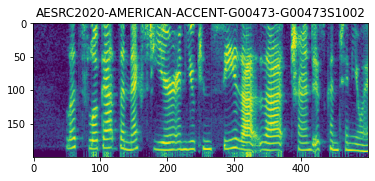

2624

In [21]:
with gzip.open(f'{outdir}train_{feature_setting}_0.pkl.gz', 'rb') as f:
    allspec = pickle.load(f)

utt = list(allspec.keys())[0]
img = allspec[utt]

plt.figure()
plt.imshow(img[:,:500])
plt.title(utt)
plt.show()

del allspec
gc.collect()

### 2.1.2 Dev data

In [23]:
all_spec={}
minmax_scaler = MinMaxScaler(feature_range=(0,1))
data_range = defaultdict(list)

all_spec, data_range = extract_feature(dev_df, spec_params, data_range)

gmin = min(data_range['min_ori'])
gmax = max(data_range['max_ori'])
print(f'Data range original    : min: {gmin} - max: {gmax}')

gmin = min(data_range['min_std'])
gmax = max(data_range['max_std'])
print(f'Data range standardized: min: {gmin} - max: {gmax}')
pickle.dump( all_spec, gzip.open( f'{outdir}dev_{feature_setting}_0.pkl.gz',   'wb' ) )

3596it [00:49, 72.36it/s] 


Data range original    : min: -80.0 - max: 1.9073486328125e-06
Data range standardized: min: -1.6011382341384888 - max: 7.598281383514404


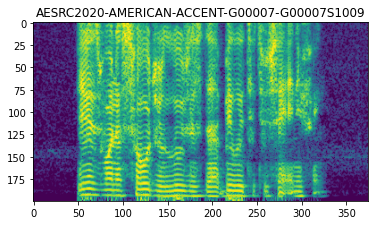

In [24]:
with gzip.open(f'{outdir}dev_{feature_setting}_0.pkl.gz', 'rb') as f:
    allspec = pickle.load(f)

utt = list(allspec.keys())[0]
img = allspec[utt]

plt.figure()
plt.imshow(img[:,:500])
plt.title(utt)
plt.show()

### 2.1.3 Test data (in-progress)

In [13]:
all_spec={}
minmax_scaler = MinMaxScaler(feature_range=(0,1))
data_range = defaultdict(list)

all_spec, data_range = extract_feature_image(test_df, spec_params, zscore_scaler, data_range)


gmin = min(data_range['min_ori'])
gmax = max(data_range['max_ori'])
print(f'Data range original    : min: {gmin} - max: {gmax}')

gmin = min(data_range['min_std'])
gmax = max(data_range['max_std'])
print(f'Data range standardized: min: {gmin} - max: {gmax}')
pickle.dump( all_spec, gzip.open( f'{outdir}test_{feature_setting}_0.pkl.gz',   'wb' ) )

0it [00:00, ?it/s]/Applications/anaconda3/envs/pykaldi/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
0it [00:00, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: 'audio/US/G00006/G00006S1259.wav'

In [ ]:
with gzip.open(f'{outdir}test_{feature_setting}_0.pkl.gz', 'rb') as f:
    allspec = pickle.load(f)

utt = list(allspec.keys())[0]
img = allspec[utt]

plt.figure()
plt.imshow(img[:,:500])
plt.title(utt)
plt.show()

In [ ]:
#to try:

#label smoothing
#focal loss
#multitask (gender)
#language identification pre-trained model?
#3-ch image: 
#    - spec, deltas
#    - spec, different resolution